### Imports

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import TypedDict, Optional, Literal
from langgraph.graph import StateGraph, END

### Initialize the LLM

In [2]:
load_dotenv()

groq_key = os.getenv("groq_api_key")
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

### Structured Output

In [3]:
# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.model_dump_json(indent=4))

{
    "search_query": "Calcium CT score and high cholesterol relationship",
    "justification": "The user is asking about the relationship between Calcium CT score and high cholesterol, so a search query is needed to find relevant information."
}


### LangGraph Example

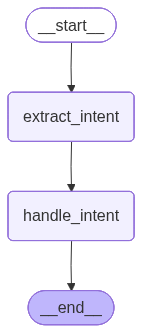

In [4]:
# 1️⃣ Define the structured output schema
class UserIntent(BaseModel):
    task: Literal["compare", "summarize", "recommend"] = Field(description="Main task user wants to perform")
    product_name: Optional[str] = Field(description="Product mentioned, if any")
    urgency: Literal["low", "medium", "high"] = Field(description="low | medium | high")

# 2️⃣ Create LLM with structured output
intent_llm = llm.with_structured_output(UserIntent)

# 3️⃣ Define LangGraph state
class GraphState(TypedDict):
    user_input: str
    intent: UserIntent
    result: str

# 4️⃣ Nodes
def extract_intent(state: GraphState):
    intent = intent_llm.invoke(state["user_input"])
    return {"intent": intent}

def handle_intent(state: GraphState):
    intent = state["intent"]

    if intent.task.lower() == "compare":
        result = f"Comparing product: {intent.product_name}"
    elif intent.task.lower() == "summarize":
        result = f"Summarizing reviews for {intent.product_name}"
    else:
        result = "Unsupported task"

    return {"result": result}

# 5️⃣ Build Graph
graph = StateGraph(GraphState)

graph.add_node("extract_intent", extract_intent)
graph.add_node("handle_intent", handle_intent)

graph.set_entry_point("extract_intent")
graph.add_edge("extract_intent", "handle_intent")
graph.add_edge("handle_intent", END)


app = graph.compile()
app

In [6]:
# 6️⃣ Run the graph
input_state = {
    "user_input": "Can you quickly provide summary of Noise Air Buds with Boat Airdopes?"
}

output = app.invoke(input_state)
output

{'user_input': 'Can you quickly provide summary of Noise Air Buds with Boat Airdopes?',
 'intent': UserIntent(task='summarize', product_name='Noise Air Buds and Boat Airdopes', urgency='high'),
 'result': 'Summarizing reviews for Noise Air Buds and Boat Airdopes'}